<a href="https://colab.research.google.com/github/MariaKraus/e3nn_qm9/blob/main/spherical_harmonics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load pytorch and check its version

import torch
print(torch.__version__)

2.5.1+cu121


In [2]:
# Install e3nn using pip

!pip install e3nn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.2/447.2 kB 9.3 MB/s eta 0:00:00


In [3]:
import e3nn

# e3nn
#  |
#  +-- o3        all about rotations and parity
#  +-- nn        modules to make neural networks
#  +-- io        utility classes for Spherical signals and Cartesian tensors

# more info at https://docs.e3nn.org/en/stable/api/e3nn.html

In [4]:
# The main class in e3nn.o3 is TensorProduct
# TensorProduct is a pytorch Module

# o3.TensorProduct                              general class to implement tensor products (optionally with parameters)
# |
# +-- o3.FullTensorProduct                      "usual" tensor product (with no parameters), give the two inputs and it deduce the outputs
# +-- o3.FullyConnectedTensorProduct            define 2 inputs and output and it connects everything together
# +-- o3.ElementwiseTensorProduct

# more info at https://docs.e3nn.org/en/stable/api/o3/o3_tp.html

In [5]:
torch.set_printoptions(3, 100000)

In [ ]:
irreps = e3nn.o3.Irreps("2x0e + 1o")
# irreps = e3nn.o3.Irreps([(2, (0, 1)), (1, (1, -1))])

R = e3nn.o3.rand_matrix()
R

tensor([[ 0.511, -0.542, -0.667],
        [ 0.021,  0.783, -0.621],
        [ 0.859,  0.304,  0.411]])

In [ ]:
irreps.D_from_matrix(R)

tensor([[ 1.000,  0.000,  0.000,  0.000,  0.000],
        [ 0.000,  1.000,  0.000,  0.000,  0.000],
        [ 0.000,  0.000,  0.511, -0.542, -0.667],
        [ 0.000,  0.000,  0.021,  0.783, -0.621],
        [ 0.000,  0.000,  0.859,  0.304,  0.411]])

In [ ]:
# Here is the e3nn way of computing: "3 x 3 = 1 + 3 + 5"

tp = e3nn.o3.FullTensorProduct("1o", "1o")
tp

FullTensorProduct(1x1o x 1x1o -> 1x0e+1x1e+1x2e | 3 paths | 0 weights)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5a76bee610>)

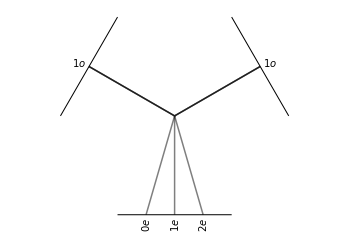

In [ ]:
# We can visualize the computation done by this class

# top-left and top-right represent the two inputs
# the bottom represents the output

tp.visualize()

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5a764ebdd0>)

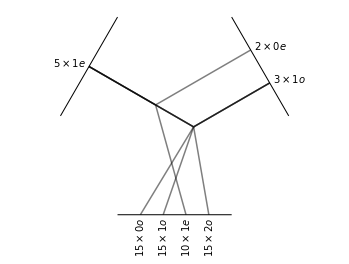

In [ ]:
t = e3nn.o3.FullTensorProduct("5x1e", "2x0e + 3x1o")

t.visualize()

In [ ]:
# Feed tp with some data

x1 = torch.tensor([1.0, 0.0, 0.0])
x2 = torch.tensor([0.0, 1.0, 0.0])

print(tp(x1, x2))

tensor([0.000, 0.000, 0.000, 0.707, 0.000, 0.707, 0.000, 0.000, 0.000])


In [ ]:
# We can add arbitrary batch dimensions

x1 = torch.randn(10, 10, 3)
x2 = torch.randn(10, 10, 3)

y = tp(x1, x2)

y.std((0, 1))

tensor([0.958, 1.097, 0.879, 0.966, 0.894, 1.004, 0.915, 1.081, 0.957])

In [ ]:
# Broadcasting works as well

x1 = torch.randn(10, 1, 3)
x2 = torch.randn(5, 3)

tp(x1, x2).shape

torch.Size([10, 5, 9])

In [ ]:
# You can filter the outputs of FullTensorProduct

# Let's compute only the cross-product

tp = e3nn.o3.FullTensorProduct("1o", "1o", ["1e"])  # filter the outputs
tp

FullTensorProduct(1x1o x 1x1o -> 1x1e | 1 paths | 0 weights)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5a763b1610>)

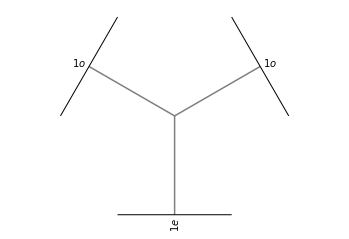

In [ ]:
tp.visualize()

In [ ]:
# Feed tp with some data

x1 = torch.tensor([1.0, 0.0, 0.0])
x2 = torch.tensor([0.0, 1.0, 0.0])

tp(x1, x2)

tensor([0.000, 0.000, 0.707])

In [ ]:
# The normalization is made such that:

# if the second moment of each component's inputs are 1
x1 = torch.randn(1000, 3)  # here are normal distributions (mean = 0 and variance = 1   => second moment = 1)
x2 = torch.randn(1000, 3)

out = tp(x1, x2)

out.pow(2).mean()  # the second moment of each component's output is 1

tensor(1.022)

In [ ]:
# Let's create the spherical harmonics of order 3 !

# Spherical harmonics of order L is:
# - equivariant polynomial
# - input is a vector
# - its degree is L
# - output representation is the irreducible representation of order L

tp1 = e3nn.o3.FullTensorProduct("1o", "1o", ["2e"])  # l=1 x l=1 = l=0 + l=1 + l=2    keep only l=2  (spherical harmonics L=2)
tp2 = e3nn.o3.FullTensorProduct("2e", "1o", ["3o"])  # l=2 x l=1 = l=1 + l=2 + l=3    keep only l=3  (spherical harmonics L=3)

def spherical_harmonic_3(r):
  """
  Args:
    r: torch.Tensor of shape [3]

  Returns:
    spherical harmonic of degree L=3 of shape [2*3+1] = [7]
  """
  y2 = tp1(r, r)
  y3 = tp2(y2, r)
  return y3

In [ ]:
spherical_harmonic_3(torch.tensor([1.0, 0.5, 1.0]))

tensor([ 1.000e+00,  1.225e+00, -3.873e-01, -8.696e-01, -3.873e-01,  8.650e-09,
        -1.000e+00])

In [ ]:
# check equivariance

irreps_in = e3nn.o3.Irreps("1o")
irreps_out = e3nn.o3.Irreps("3o")

# random inputs
x_in = irreps_in.randn(100, -1)

angles = e3nn.o3.rand_angles()

x_out1 = spherical_harmonic_3(torch.einsum("ij,zj->zi", irreps_in.D_from_angles(*angles), x_in))
x_out2 = torch.einsum("ij,zj->zi", irreps_out.D_from_angles(*angles), spherical_harmonic_3(x_in))

(x_out1 - x_out2).abs().max()

tensor(4.822e-05)

In [ ]:
rtp = e3nn.o3.ReducedTensorProducts('ijk=jik=ikj', i='1x1o', filter_ir_out=['3o'])
rtp

ReducedTensorProducts(
    in: 1x1o times 1x1o times 1x1o
    out: 1x3o
)

In [ ]:
rtp.change_of_basis.shape

spherical_harmonic_3 = lambda x: rtp(x, x, x)

In [ ]:
# e3nn has optimized function for spherical harmonics
irreps_in = e3nn.o3.Irreps("1o")
x_in = irreps_in.randn(100, -1)

x_out1 = e3nn.o3.spherical_harmonics(3, x_in, False)
x_out2 = spherical_harmonic_3(x_in)

# they are the same up to a constant
# o3.spherical_harmonics are normalized on the sphere
(1.180093 * x_out2 - x_out1).abs().max()

tensor(0.0002)

In [ ]:
# Let's draw the spherical harmonics on the sphere!

import plotly.graph_objects as go

In [ ]:
alpha, beta = torch.meshgrid(
    torch.linspace(0.0, 2 * torch.pi, 30),
    torch.linspace(0.0, torch.pi, 30),
    indexing="ij"
)

vectors = e3nn.o3.angles_to_xyz(alpha, beta)  # Vectors on the surface of the sphere

go.Figure([go.Surface(
    x=vectors[..., 0].numpy(),
    y=vectors[..., 1].numpy(),
    z=vectors[..., 2].numpy(),
)])

In [ ]:
vectors.shape

torch.Size([30, 30, 3])

In [ ]:
out = spherical_harmonic_3(vectors)

cmap_bwr = [[0, 'rgb(0,50,255)'], [0.5, 'rgb(200,200,200)'], [1, 'rgb(255,50,0)']]

go.Figure([go.Surface(
    x=vectors[..., 0].numpy(),
    y=vectors[..., 1].numpy(),
    z=vectors[..., 2].numpy(),
    surfacecolor=out[..., 3].numpy(),

    colorscale=cmap_bwr, cmin=-0.4, cmax=0.4
)])

In [ ]:
out.shape

torch.Size([30, 30, 7])

In [ ]:
# Let's deform the surface of the sphere proportionally to the amplitude of the signal

signal = out[..., 3]

go.Figure([go.Surface(
    x=(signal.abs() * vectors[..., 0]).numpy(),
    y=(signal.abs() * vectors[..., 1]).numpy(),
    z=(signal.abs() * vectors[..., 2]).numpy(),
    surfacecolor=signal.numpy(),

    colorscale=cmap_bwr, cmin=-0.4, cmax=0.4
)])